In [1]:
import os
import re 
import json 
import string 
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig

import pandas as pd

In [2]:
learning_rate=7.5e-6 
max_len = 512 
configuration = BertConfig() 
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")

save_path = "bert_base_chinese/"
if not os.path.exists(save_path):
     os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path) 


C:\Users\magic\miniconda3\envs\tf2.10GPU_py3.10.13\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


('bert_base_chinese/tokenizer_config.json',
 'bert_base_chinese/special_tokens_map.json',
 'bert_base_chinese/vocab.txt',
 'bert_base_chinese/added_tokens.json')

In [3]:
tokenizer = BertWordPieceTokenizer("bert_base_chinese/vocab.txt", lowercase=True) 


'\n中文文本编码的处理方法如下：\n利用transformers库中的BertTokenizer实现分词编码，实例化一个tokenizer，载入预先下载好的词表，调用encode函数进行编码，encode函数有5个常用参数：\n        ① text： 需要编码的文本；\n        ② add_special_tokens： 是否添加特殊token，即CLS分类token和SEP分隔token；默认True。\n        ③ max_length： 文本的最大长度，根据需要处理的最长文本长度设置；\n        ④ pad_to_max_length： 是否填充到最大长度，以0补位；默认False。\n        ⑤ return_tensors：tensor类型4种[‘pt’, ‘tf’, ‘np’, ‘jax’]即pytorch、tensorflow、int32数组和jax；不指定return_tensors类型则返回列表格式。\n四种tensor类型如下：\n1、pytorch tensor：\ninput_ids:\n tensor([[ 101,  671, 2573, 3299, 5862, 8024,  671, 2573, 6716, 7231, 8024,  671,\n         2573, 1068, 2255, 7410, 3868, 6814,  511, 3470, 6864, 6814, 2145, 8024,\n         2809, 2094, 5442,  679, 7309, 1728, 3362,  511,  102,    0,    0,    0,\n            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,\n            ......\n            0,    0,    0,    0,    0,    0,    0,    0]])\n2、tensorflow tensor：\ninput_ids:\n tf.Tensor(\n[[ 101  671 2573 3299 5862 8024  671 2573 6716 7231 8024  67

In [4]:
#文本格式的数据集
df = pd.read_excel('bridge QA 2024.07.25.xlsx')
print(df.head())
print(df.info(),'\n')

def split_data(data, validate_number=20, test_number=6): 
    shuffled_indices = np.random.permutation(len(data))
    test_indices = shuffled_indices[:test_number]
    validate_indices = shuffled_indices[test_number:test_number+validate_number]
    train_indices = shuffled_indices[test_number+validate_number:]
    return data.iloc[train_indices], data.iloc[validate_indices], data.iloc[test_indices]
train_set, validate_set, test_set = split_data(df, validate_number=20, test_number=6)
print(len(train_set),len(validate_set),len(test_set)) #200，20，6
print( validate_set.head() )


                                             context  \
0  3.\t1.1 公路桥涵应根据公路功能和技术等级，考虑因地制宜、就地取材、便于施工和养护等因...   
1  3.\t1.1 公路桥涵应根据公路功能和技术等级，考虑因地制宜、就地取材、便于施工和养护等因...   
2  3.\t1.1 公路桥涵应根据公路功能和技术等级，考虑因地制宜、就地取材、便于施工和养护等因...   
3  3.\t1.1 公路桥涵应根据公路功能和技术等级，考虑因地制宜、就地取材、便于施工和养护等因...   
4  3.\t1.1 公路桥涵应根据公路功能和技术等级，考虑因地制宜、就地取材、便于施工和养护等因...   

                       question                                answer  \
0             公路桥涵总体设计时应考虑哪些因素？                    因地制宜、就地取材、便于施工和养护等   
1  公路桥涵在多长时间内应满足规定的正常交通荷载通行的需要？                                设计使用年限   
2             中小桥涵线形设计应该符合什么规定？                             路线设计的总体要求   
3              大桥线形设计应综合考虑哪些因素？  路线总体走向、桥区地质、地形、安全通行、通航、已有建筑设施、环境敏感区等   
4             特大桥线形设计应综合考虑哪些因素？  路线总体走向、桥区地质、地形、安全通行、通航、已有建筑设施、环境敏感区等   

   index_of_answer  number_of_same_answer  
0                0                      1  
1                0                      1  
2                0                      1  
3                0                      1  
4   

"\nprint(train_set.head())\nprint(validate_set.head())\nprint(test_set.head())\nprint(test_set['answer'])\n"

In [5]:
def start_and_end_token_idx(context_ids, answer_ids, index_of_answer):
    answer_ids=answer_ids[1:-1] 
    answer_ids_len=len(answer_ids)

    answer_ids = ' '.join([str(i) for i in answer_ids]) 

    context_ids = ' '.join([str(i) for i in context_ids]) 
 
    context_ids=context_ids.replace(answer_ids,"#") 

    context_ids=context_ids.split() 
 
    
    times=0
    for i,value in enumerate(context_ids):
        if value=="#":
            if times==index_of_answer:
                return i+(answer_ids_len-1)*times, i+(answer_ids_len-1)*times+(answer_ids_len-1)    
            times +=1


In [6]:
class BridgeExample: 
     def __init__(self, question_text, context_text, answer_text, index_of_answer):
         self.question = question_text
         self.context = context_text
         self.answer = answer_text
         self.index_of_answer = index_of_answer 
         self.skip = False 
     def preprocess(self):
         context = " ".join(str(self.context).split()) 
         question = " ".join(str(self.question).split()) 
         answer = " ".join(str(self.answer).split())

         tokenized_question = tokenizer.encode(question)
         tokenized_context = tokenizer.encode(context)
         tokenized_answer = tokenizer.encode(answer)

         start_token_idx,end_token_idx=start_and_end_token_idx(tokenized_context.ids, tokenized_answer.ids, self.index_of_answer)


         input_ids = tokenized_context.ids + tokenized_question.ids[1:] 
         token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(tokenized_question.ids[1:]) 
         attention_mask = [1] * len(input_ids) 



         padding_length = max_len - len(input_ids)
         if padding_length > 0: 
             input_ids = input_ids + ([0] * padding_length) 
             attention_mask = attention_mask + ([0] * padding_length) 
             token_type_ids = token_type_ids + ([0] * padding_length)
         elif padding_length < 0:
             self.skip = True
             print("There is an example skip because of padding_length < 0")
             return
         

         self.input_ids = input_ids #样本
         self.token_type_ids = token_type_ids #样本
         self.attention_mask = attention_mask #样本
         self.start_token_idx = start_token_idx #标签
         self.end_token_idx = end_token_idx #标签



In [7]:
def create_bridge_examples(raw_data): 
    bridge_examples = []

    for i in range( len(raw_data["context"]) ):
        context_text = raw_data.iloc[i]["context"] #上下文
        question_text = raw_data.iloc[i]["question"] #问题
        answer_text = raw_data.iloc[i]["answer"] #回答
        index_of_answer = raw_data.iloc[i]["index_of_answer"] #回答的索引（上下文存在多个与答案相同的片段。索引从0开始计数）

        bridge_eg = BridgeExample(question_text, context_text, answer_text, index_of_answer)
        bridge_eg.preprocess() 
        bridge_examples.append(bridge_eg)
    return bridge_examples 

def create_inputs_targets(bridge_examples): 
     dataset_dict = {
         "input_ids": [],#样本的成员
         "token_type_ids": [],#样本的成员
         "attention_mask": [],#样本的成员
         "start_token_idx": [],#标签的成员
         "end_token_idx": [],#标签的成员
     }
     for item in bridge_examples:
         if item.skip == False: #有效样本
             for key in dataset_dict:
                 dataset_dict[key].append(getattr(item, key)) 

     for key in dataset_dict:
         dataset_dict[key] = np.array(dataset_dict[key])

     x = [ dataset_dict["input_ids"], dataset_dict["token_type_ids"], dataset_dict["attention_mask"] ]#样本
     y = [ dataset_dict["start_token_idx"], dataset_dict["end_token_idx"] ]#标签
     return x, y

In [8]:
train_bridge_examples = create_bridge_examples(train_set) #训练集
x_train, y_train = create_inputs_targets(train_bridge_examples) 
print(f"{len(train_bridge_examples)} training points created.")

eval_bridge_examples = create_bridge_examples(validate_set) #验证集
x_eval, y_eval = create_inputs_targets(eval_bridge_examples)
print(f"{len(eval_bridge_examples)} evaLuation points created.")

test_bridge_examples = create_bridge_examples(test_set) #测试集
x_test, y_test = create_inputs_targets(test_bridge_examples)
print(f"{len(test_bridge_examples)} test points created.")



200 training points created.
20 evaLuation points created.
6 test points created.


'\nprint(len(x_eval)) #len(x_eval)=3\nprint(len(y_eval)) #len(y_eval)=2\n\nx_eval= [array([[ 101, 3565, 4605, ...,    0,    0,    0],\n       [ 101, 3565, 4605, ...,    0,    0,    0],\n       [ 101, 3565, 4605, ...,    0,    0,    0],\n       ...,\n       [ 101, 1996, 9044, ...,    0,    0,    0],\n       [ 101, 1996, 9044, ...,    0,    0,    0],\n       [ 101, 1996, 9044, ...,    0,    0,    0]]), array([[0, 0, 0, ..., 0, 0, 0],\n       [0, 0, 0, ..., 0, 0, 0],\n       [0, 0, 0, ..., 0, 0, 0],\n       ...,\n       [0, 0, 0, ..., 0, 0, 0],\n       [0, 0, 0, ..., 0, 0, 0],\n       [0, 0, 0, ..., 0, 0, 0]]), array([[1, 1, 1, ..., 0, 0, 0],\n       [1, 1, 1, ..., 0, 0, 0],\n       [1, 1, 1, ..., 0, 0, 0],\n       ...,\n       [1, 1, 1, ..., 0, 0, 0],\n       [1, 1, 1, ..., 0, 0, 0],\n       [1, 1, 1, ..., 0, 0, 0]])]\ny_eval= [array([ 34,  45,  80, ...,  68, 171, 158]), array([ 35,  46,  83, ...,  68, 172, 160])]\n'

In [10]:
def create_model():
     encoder = TFBertModel.from_pretrained("bert-base-chinese") 
     input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
     token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
     attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
     embedding = encoder(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
     start_logits = layers.Dense(1, name="start_logit", use_bias=False)(embedding)
     start_logits = layers.Flatten()(start_logits)
     end_logits = layers.Dense(1, name="end_logit", use_bias=False)(embedding)
     end_logits = layers.Flatten()(end_logits)
     start_probs = layers.Activation(keras.activations.softmax)(start_logits)
     end_probs = layers.Activation(keras.activations.softmax)(end_logits)
     model = keras.Model( inputs=[input_ids, token_type_ids, attention_mask], outputs=[start_probs, end_probs] )
     loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False) 
     optimizer = keras.optimizers.Adam(lr=learning_rate)
     model.compile(optimizer=optimizer, loss=[loss, loss], metrics=['accuracy']) 
     return model

In [11]:
model = create_model()
model.summary()

C:\Users\magic\miniconda3\envs\tf2.10GPU_py3.10.13\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly id

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  102267648   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_3[0][0]',            

C:\Users\magic\miniconda3\envs\tf2.10GPU_py3.10.13\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
class ExactMatch(keras.callbacks.Callback):
     def __init__(self, x_eval, y_eval):
         self.x_eval = x_eval
         self.y_eval = y_eval
     def on_epoch_end(self, epoch, logs=None):
         pred_start, pred_end = self.model.predict(self.x_eval) 
         count = 0
         for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
             start = np.argmax(start) 
             end = np.argmax(end)
             if start == self.y_eval[0][idx] and end == self.y_eval[1][idx]: 
                 count += 1 
         acc = count / len(self.y_eval[0])
         print(f"\nepoch={epoch+1}, exact match score={acc:.2f}")
         #self.model.save_weights('./save_weights/my_model_%03d.h5'%epoch) #每轮均保存模型

In [15]:
def predict_result(x_data, y_data, show=False):
    pred_start, pred_end = model.predict(x_data)
    count = 0
    for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
        start = np.argmax(start) 
        end = np.argmax(end)
        if start == y_data[0][idx] and end == y_data[1][idx]: 
            count += 1 
    acc = count / len(y_data[0])    
    print('样本数量=',len(y_data[0]))
    print(f"精度={acc:.0%}", "\n") 
    if show:
        for num_of_example in range( len(y_data[0]) ):
            context_AND_question=tokenizer.decode(x_data[0][num_of_example]) 
            print('context_AND_question=',context_AND_question)
            label=tokenizer.decode(x_data[0][num_of_example][y_data[0][num_of_example] : y_data[1][num_of_example]+1]) 
            print('label=',y_data[0][num_of_example] , y_data[1][num_of_example],"\n",label)
            answer_start = np.argmax(pred_start[num_of_example])
            answer_end = np.argmax(pred_end[num_of_example])
            label=tokenizer.decode(x_data[0][num_of_example][answer_start : answer_end+1])
            print('预测=',answer_start,answer_end,"\n",label, "\n")

        
#predict_result(x_train, y_train, show=False) 
#predict_result(x_eval, y_eval, show=False) 
predict_result(x_test, y_test, show=True) 



1/1 [==============================] - 1s 519ms/step
样本数量= 6
精度=100% 

context_AND_answer= 3. 4. 3 桥 下 净 空 应 根 据 计 算 水 位 （ 设 计 水 位 计 入 壅 水 、 浪 高 等 ） 或 最 高 流 冰 水 位 加 安 全 高 度 确 定 ， 并 应 符 合 下 列 规 定 ： 1 当 河 流 有 形 成 流 冰 阻 塞 的 危 险 或 有 漂 浮 物 通 过 时 ， 应 按 实 际 调 查 的 数 据 ， 在 计 算 水 位 的 基 础 上 ， 结 合 当 地 具 体 情 况 酌 留 一 定 富 余 量 ， 作 为 确 定 桥 下 净 空 的 依 据 。 对 于 有 淤 积 的 河 流 ， 桥 下 净 空 应 适 当 增 加 。 2 通 航 或 流 放 木 筏 的 河 流 ， 桥 下 净 空 应 符 合 通 航 标 准 或 流 放 木 筏 的 要 求 。 有 国 防 要 求 和 其 他 特 殊 要 求 （ 如 石 油 钻 探 船 只 ） 的 航 道 ， 其 通 航 标 准 应 与 有 关 部 门 具 体 研 究 确 定 。 3 在 不 通 航 或 无 流 放 木 筏 河 流 上 及 通 航 河 流 的 不 通 航 桥 孔 内 ， 桥 下 净 空 不 应 小 于 表 3. 4. 3 的 规 定 。 4 无 铰 拱 的 拱 脚 允 许 被 设 计 洪 水 淹 没 ， 但 不 宜 超 过 拱 圈 高 度 的 2 / 3, 且 拱 顶 底 面 至 计 算 水 位 的 净 高 不 得 小 于 1. 0m 。 5 在 不 通 航 和 无 流 筏 的 水 库 区 域 内 ， 梁 底 面 或 无 铰 拱 拱 顶 底 面 离 开 水 面 的 高 度 不 应 小 于 计 算 浪 高 的 0. 75 倍 加 上 0. 25m 。 无 铰 拱 的 拱 脚 被 设 计 洪 水 淹 没 时 ， 不 宜 超 过 什 么 高 度 的 2 / 3 ？
label= 287 288 
 拱 圈
预测= 287 288 
 拱 圈 

context_AND_answer= 3. 8. 1 桥 涵 应 设 置 维 修 养 护 通 道 。 特 大 、 大 桥 应 根 据 需 要 设 置 必 

In [15]:
#history=model.fit( x_train, y_train, epochs=2, batch_size=8, callbacks=[ExactMatch(x_eval, y_eval)])  
history=model.fit( x_train, y_train, epochs=2, batch_size=8, validation_data=(x_eval, y_eval) )  



Epoch 1/2
1/1 [==============================] - 0s 434ms/steposs: 2.6845 - activation_loss: 1.1720 - activation_1_loss: 1.5125 - activation_accuracy: 0.6750 - activation_1_accuracy: 0.58

epoch=1, exact match score=0.45
25/25 [==============================] - 13s 507ms/step - loss: 2.6845 - activation_loss: 1.1720 - activation_1_loss: 1.5125 - activation_accuracy: 0.6750 - activation_1_accuracy: 0.5800
Epoch 2/2
1/1 [==============================] - 0s 437ms/steposs: 1.2213 - activation_loss: 0.5425 - activation_1_loss: 0.6788 - activation_accuracy: 0.8600 - activation_1_accuracy: 0.81

epoch=2, exact match score=0.60
25/25 [==============================] - 13s 507ms/step - loss: 1.2213 - activation_loss: 0.5425 - activation_1_loss: 0.6788 - activation_accuracy: 0.8600 - activation_1_accuracy: 0.8100


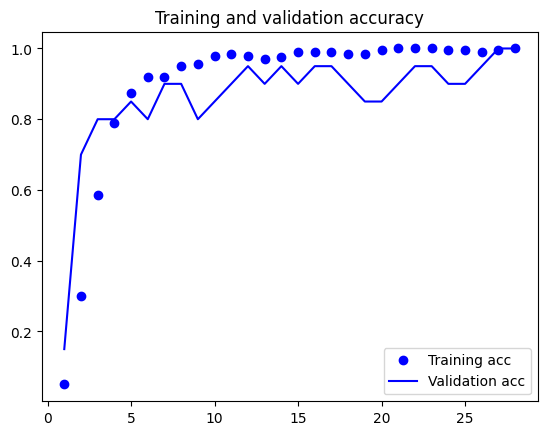

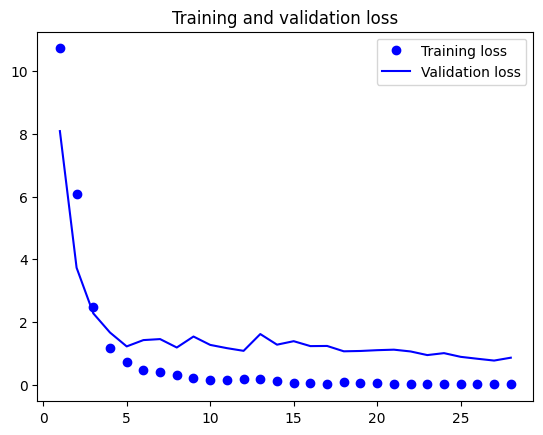

In [22]:

with open(os.path.join('history.txt'), 'w') as file_object:
    file_object.write(str(history.history))

import matplotlib.pyplot as plt
a=28
acc = history.history['activation_1_accuracy'][0:a]
val_acc = history.history['val_activation_1_accuracy'][0:a]
loss = history.history['loss'][0:a]
val_loss = history.history['val_loss'][0:a]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [1]:
model.load_weights('01 my_model_038.h5')

predict_result(x_train, y_train, show=False) 
predict_result(x_eval, y_eval, show=False) 
predict_result(x_test, y_test, show=True) 

NameError: name 'model' is not defined